# Tasca M8 T01

##### Importing libraries

In [125]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#Preprocesamiento
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
!pip install kneed # To install only knee-detection algorithm
from kneed import DataGenerator, KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Exercici 1
### Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

#### Carga, analisis y "cleaning" del DataFrame

Vamos a trabajar sobre un dataset con datos de Facebook Thailandia sobre las reacciones a 4 diferentes tipos de publicaciones ['video', 'photo', 'link', 'status'].

Además del tipo de reacción, nos encontramos la columna con fecha y hora de publicación así como la columna de número de reacciones generadas por la publicación, las veces que se ha compartido y el número de "likes". Adicionalmente las reacciones están subdivididas por tipo de reacción (num_shares, num_likes, num_loves, num_wows, num_hahas, num_sads, num_angrys) 

Finalmente hay 4 columnas sin información relevante que eliminaremos junto con la columna status_id ya que la información que contiene no tiene ninguna utilidad para nosotros.



In [70]:
#https://github.com/Huanhotze/Sprint-8.-Algoritmes-daprenentatge-NO-supervisat-Agrupacio/blob/main/M8%20DATA/Publicacions%20Facebook%20Thailandia.csv
url = 'https://raw.githubusercontent.com/Huanhotze/Sprint-8.-Algoritmes-daprenentatge-NO-supervisat-Agrupacio/main/M8%20DATA/Publicacions%20Facebook%20Thailandia.csv'
df = pd.read_csv(url)
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [71]:
df.status_type.unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

In [72]:
np.unique(df[["Column1", "Column2","Column3", "Column4"]])

array([nan])

In [73]:
df = df.drop(["Column1", "Column2","Column3", "Column4", "status_id"], axis=1)

In [74]:
df.dtypes

status_type         object
status_published    object
num_reactions        int64
num_comments         int64
num_shares           int64
num_likes            int64
num_loves            int64
num_wows             int64
num_hahas            int64
num_sads             int64
num_angrys           int64
dtype: object

In [75]:
df['status_published'] = pd.to_datetime(df['status_published'])

Hemos transformado la columna "status_published" de objeto a datetime64. Aunque más adelanta observaremos que esta columna tampoco es necesaria 😅

In [76]:
df.isnull().values.any()

False

In [77]:
df.isna().values.any()

False

No tenemos nulos.

In [78]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num_reactions,7050.0,230.117163,462.625309,0.0,17.0,59.5,219.00,4710.0
num_comments,7050.0,224.356028,889.636820,0.0,0.0,4.0,23.00,20990.0
num_shares,7050.0,40.022553,131.599965,0.0,0.0,0.0,4.00,3424.0
num_likes,7050.0,215.043121,449.472357,0.0,17.0,58.0,184.75,4710.0
num_loves,7050.0,12.728652,39.972930,0.0,0.0,0.0,3.00,657.0
num_wows,7050.0,1.289362,8.719650,0.0,0.0,0.0,0.00,278.0
num_hahas,7050.0,0.696454,3.957183,0.0,0.0,0.0,0.00,157.0
num_sads,7050.0,0.243688,1.597156,0.0,0.0,0.0,0.00,51.0
num_angrys,7050.0,0.113191,0.726812,0.0,0.0,0.0,0.00,31.0


In [79]:
df.tail(10)

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
7040,photo,2016-09-25 13:29:00,93,26,34,90,3,0,0,0,0
7041,photo,2016-09-24 08:15:00,9,0,0,7,2,0,0,0,0
7042,photo,2016-09-24 06:07:00,4,0,0,4,0,0,0,0,0
7043,photo,2016-09-24 05:07:00,196,2,3,195,1,0,0,0,0
7044,photo,2016-09-24 04:37:00,86,0,0,86,0,0,0,0,0
7045,photo,2016-09-24 02:58:00,89,0,0,89,0,0,0,0,0
7046,photo,2016-09-23 11:19:00,16,0,0,14,1,0,1,0,0
7047,photo,2016-09-21 23:03:00,2,0,0,1,1,0,0,0,0
7048,photo,2016-09-20 00:43:00,351,12,22,349,2,0,0,0,0
7049,photo,2016-09-10 10:30:00,17,0,0,17,0,0,0,0,0


#### Preprocesado

Haremos los siguientes pasos:

* Separaremos el DataFrame en X e y
* Convertiremos las variables categoricas en variables tipo númerico
* Escalaremos las columnas que lo requieran
* Eliminaremos la columna status_published que hace referencia a la hora y fecha de publicación no nos será de utilidad

In [80]:
#Declarationg of feature vector and target variable
X = df.drop(['status_published'], axis=1) #La columna que hace referencia a la hora y fecha de publicación no nos será de utilidad
y = df['status_type']

#Convert categorical variable into integers
le = LabelEncoder() 
X['status_type'] = le.fit_transform(X['status_type'])
y = le.transform(y)

X.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,3,529,512,262,432,92,3,1,1,0
1,1,150,0,0,150,0,0,0,0,0
2,3,227,236,57,204,21,1,1,0,0
3,1,111,0,0,111,0,0,0,0,0
4,1,213,0,0,204,9,0,0,0,0


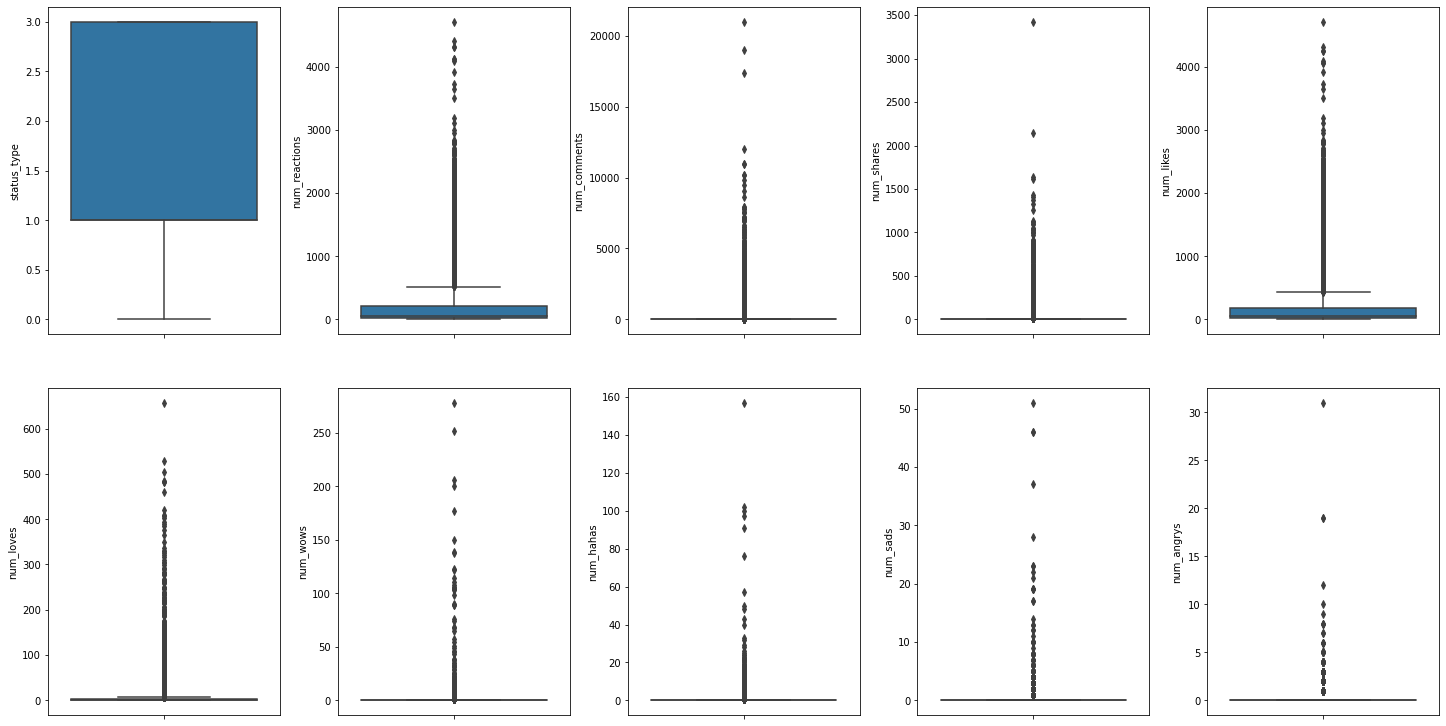

In [81]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in X.items():
    sns.boxplot(y=k, data=X, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Encontramos Outlayers, en todas las columnas excepto en status_type. Utilizaremos RobustScaler en todas excepto status_type donde aplicaremos MinMax. 

In [82]:
columnsMinMax = ['status_type']
scalerMM = MinMaxScaler().fit(X[columnsMinMax])
X[columnsMinMax] = scalerMM.transform(X[columnsMinMax])


columnsRobust =  ['num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys']
scalerRobust = RobustScaler().fit(X[columnsRobust])
X[columnsRobust] = scalerRobust.transform(X[columnsRobust])

#### PCA - Principal Component Analysis

Antes de trabajar con K-Means aplicaremos PCA para reducir el número de columnas a trabajar.

Text(0, 0.5, 'Cumulative explained variance')

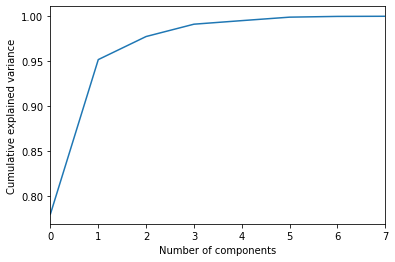

In [83]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Realizaremos un PCA y nos quedaremos con 2 componentes, de esta forma además podremos graficarlo de forma sencilla en dos dimensiones.

In [84]:
pca = PCA(n_components=2)

Xpca = pca.fit_transform(X)
Xpca

array([[ 49.09947491,  37.98545119],
       [-14.52757434,  -2.02158442],
       [  3.54686923,   3.33820033],
       ...,
       [-14.4736705 ,  -1.95482035],
       [-10.60721733,   1.67759665],
       [-14.54155177,  -2.04319448]])

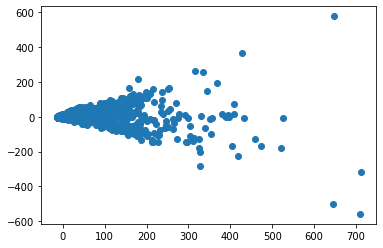

In [85]:
fig, ax = plt.subplots()
ax.scatter(x=Xpca[:,0], y=Xpca[:,1])

En la siguiente tabla veremos la relación entre las columnas originales y las nuevas columnas creadas tras el PCA.

En un peso concreto en el número de comentarios y en el número de veces compartido.

In [86]:
col = list(X.columns)
attributes_pca = pd.DataFrame({'Attribute' : col, 'PC_1': pca.components_[0], 'PC_2': pca.components_[1]})
attributes_pca.style.highlight_max(['PC_1', 'PC_2'])

,Attribute,PC_1,PC_2
0,status_type,0.002597,0.001572
1,num_reactions,0.010807,0.016320
2,num_comments,0.759996,-0.647254
3,num_shares,0.611600,0.695018
4,num_likes,0.008655,0.013703
5,num_loves,0.208528,0.272679
6,num_wows,0.058385,0.149854
7,num_hahas,0.034210,0.026881
8,num_sads,0.008320,-0.001499
9,num_angrys,0.004580,0.004620


#### Clasificación con K-means

In [87]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(Xpca)

y_pred = kmeans.predict(Xpca)

Una vez entrenado el modelo con K-means, lo representaremos graficamente para ver de una forma visual la separación de los 4 grupos creados.

* *Comentario tras finalizar la tarea: Tras finalizar la tarea me he dado cuenta que no había aplicado el Knee point para definir el número de cluster y que directamente he elegido 4 😅. Como el ejercicio teórico es correcto, simplemente he añadido un punto al final de todo calculando el Knee point y añadiendo una pequeña conclusión de la diferencia de resultados entre 4 y 3 clusters que son los que recomienda knee point.*

Text(0.5, 1.0, 'VISUALIZATION OF CLUSTERS')

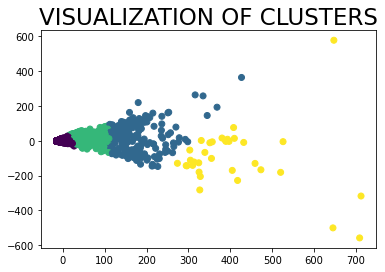

In [88]:
fig, ax = plt.subplots()
ax.scatter(x=Xpca[:,0], y=Xpca[:,1], c=y_pred)
plt.title('VISUALIZATION OF CLUSTERS', fontsize = 23)

En el siguiente grafico podremos apreciar donde a ubicado K-means el centro de cada uno de los grupos.

Text(0.5, 1.0, 'VISUALIZATION OF CLUSTERS')

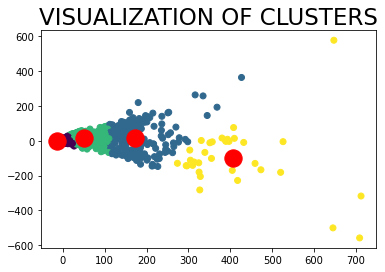

In [89]:
fig, ax = plt.subplots()
ax.scatter(x=Xpca[:,0], y=Xpca[:,1], c=y_pred)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('VISUALIZATION OF CLUSTERS', fontsize = 23)


Por último y para darle una aspecto más practico a la clasificación, incorporaremos la agrupación a nuestra dataframe original.

In [90]:
df['Cluster'] = y_pred
df.Cluster.unique()

array([2, 0, 1, 3], dtype=int32)

In [91]:
df.groupby(['Cluster'])[['num_comments','num_shares']].agg(['count', np.mean, max, min]).round(2)

num_comments                       num_shares                  
               count     mean    max   min      count    mean   max min
Cluster                                                                
0               6209    27.54   1186     0       6209    4.29   153   0
1                204  2976.55   6407    18        204  503.90  2139  60
2                603   834.50   3146     3        603  209.65   564  26
3                 34  8832.15  20990  2903         34  774.62  3424  25

Text(0.5, 1.0, 'Histogram of clusters')

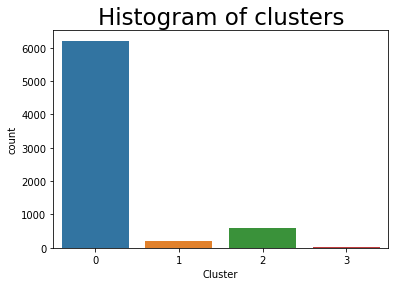

In [92]:
pl = sns.countplot(x=df['Cluster'])
pl.set_title("Histogram of clusters", fontsize = 23)

Podemos apreciar claramente la agrupación que se ha realizado a ponderado significativamente el grupo 0 con mas de 6000 posiciones y dejando los otres 3 grupos con menso de 1000 posiciones cada uno.

**En el clusters 0, el mas numerosos, se concentran las entradas con menos comentarios y número de veces compartido.**

## Exercici 2
###  Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.



Primero reduciremos el dataframe al 10% para agilizar los calculos

In [93]:
df_jerarquic = df.sample(frac=.10, random_state=7)
df_jerarquic.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
num_reactions,705.0,241.41,506.30,0.0,18.0,65.0,215.0,4710.0
num_comments,705.0,173.19,596.84,0.0,0.0,5.0,22.0,6523.0
num_shares,705.0,33.43,102.77,0.0,0.0,0.0,4.0,905.0
num_likes,705.0,229.04,500.29,0.0,18.0,62.0,184.0,4710.0
num_loves,705.0,10.60,30.32,0.0,0.0,0.0,3.0,291.0
num_wows,705.0,0.80,3.49,0.0,0.0,0.0,0.0,76.0
num_hahas,705.0,0.55,1.92,0.0,0.0,0.0,0.0,22.0
num_sads,705.0,0.25,1.40,0.0,0.0,0.0,0.0,23.0
num_angrys,705.0,0.18,1.50,0.0,0.0,0.0,0.0,31.0
Cluster,705.0,0.20,0.58,0.0,0.0,0.0,0.0,3.0


Repetimos el mismo proceso de preprocesado y escalado del ejerciocio 1 en el nuevo dataframe

In [94]:
#Declarationg of feature vector and target variable
df_jerarquic = df_jerarquic.drop(['status_published'], axis=1) #La columna que hace referencia a la hora y fecha de publicación no nos será de utilidad

#Convert categorical variable into integers
le = LabelEncoder() 
df_jerarquic['status_type'] = le.fit_transform(df_jerarquic['status_type'])

#Scaling
columnsMinMax = ['status_type']
scalerMM = MinMaxScaler().fit(df_jerarquic[columnsMinMax])
df_jerarquic[columnsMinMax] = scalerMM.transform(df_jerarquic[columnsMinMax])


columnsRobust =  ['num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys']
scalerRobust = RobustScaler().fit(df_jerarquic[columnsRobust])
df_jerarquic[columnsRobust] = scalerRobust.transform(df_jerarquic[columnsRobust])

df_jerarquic.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Cluster
5138,1.000000,-0.015228,4.409091,19.00,-0.030120,0.666667,0.0,3.0,0.0,0.0,0
479,0.333333,1.020305,0.136364,0.00,1.156627,3.000000,3.0,0.0,0.0,0.0,0
6218,0.333333,0.614213,0.454545,0.25,0.662651,1.000000,11.0,0.0,0.0,0.0,0
852,1.000000,0.568528,6.363636,0.75,0.686747,0.000000,1.0,0.0,0.0,0.0,0
4637,1.000000,0.482234,-0.181818,4.00,0.578313,0.333333,0.0,1.0,0.0,0.0,0


Aplicamos PCA pasando a 2 columnas como en el ejercicio anterior

In [95]:
pca = PCA(n_components=2)
df_jerarquic_pca = pca.fit_transform(df_jerarquic)

Entrenaremos el modelo Hierarchical clustering

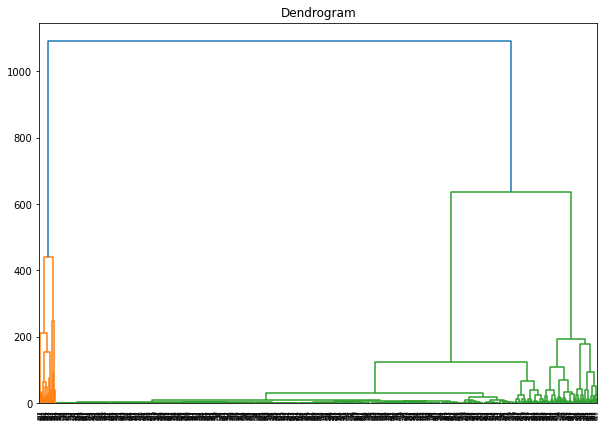

In [96]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(df_jerarquic_pca, method='ward'))

In [97]:
agg_cl = AgglomerativeClustering(n_clusters=4)
agg_cl.fit_predict(df_jerarquic_pca)

array([2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,

Text(0.5, 1.0, 'VISUALIZATION OF CLUSTERS')

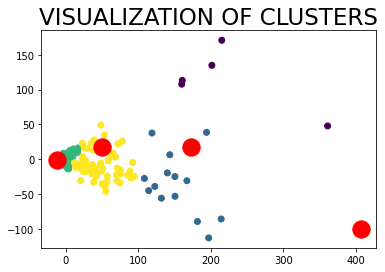

In [98]:
fig, ax = plt.subplots()
ax.scatter(x=df_jerarquic_pca[:,0], y=df_jerarquic_pca[:,1], c=agg_cl.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('VISUALIZATION OF CLUSTERS', fontsize = 23)

Pasaremos los resultados al dataframe para poder visualizarlos

In [99]:
df_jerarquic['Cluster']=agg_cl.labels_
df_jerarquic.Cluster.unique()

array([2, 3, 1, 0])

Text(0.5, 1.0, 'Histogram of clusters')

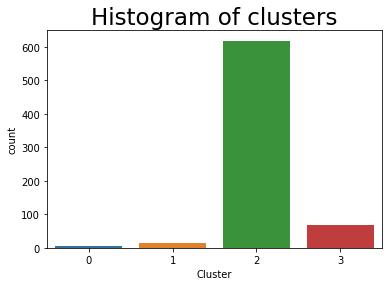

In [100]:
pl = sns.countplot(x=df_jerarquic['Cluster'])
pl.set_title("Histogram of clusters", fontsize = 23)

A nivel visual los resultados son muy parecidos a los anteriores. Un grupo mayor de 6000 y otros 3 grupos menores que no llegan a 1000. (Tenemos en cuenta que estamos trabajando con el 10% del DataFrame)

In [101]:
print("Entrenamiento con Hierarchical clustering")
print('\n')
df_jerarquic.groupby(['Cluster'])[['num_comments','num_shares']].agg(['count', np.mean, max, min]).round(2)

Entrenamiento con Hierarchical clustering




num_comments                         num_shares                       
               count    mean     max     min      count    mean     max    min
Cluster                                                                       
0                  5  243.83  296.27  196.86          5   78.30  219.75  29.50
1                 15   93.46  172.00   56.32         15  134.98  226.25  67.25
2                618    0.85   30.55   -0.23        618    0.82   22.00   0.00
3                 67   33.47   80.50    0.50         67   44.30   87.25   7.25

In [102]:
print("Entrenamiento con K-Means")
print('\n')
df.groupby(['Cluster'])[['num_comments','num_shares']].agg(['count', np.mean, max, min]).round(2)

Entrenamiento con K-Means




num_comments                       num_shares                  
               count     mean    max   min      count    mean   max min
Cluster                                                                
0               6209    27.54   1186     0       6209    4.29   153   0
1                204  2976.55   6407    18        204  503.90  2139  60
2                603   834.50   3146     3        603  209.65   564  26
3                 34  8832.15  20990  2903         34  774.62  3424  25

Apreciando los resultados númericos podemos decir que la agrupación es similar aunque no identica. 

Si nos centramos en el grupo más numerosos se aprecia rápidamente que Hierarchical clustering ha sido más agresivo (a la baja) a la hora de agrupar los comentarios y veces compartidos reduciendo el rango aún más respecto a K-Means

## Exercici 3
### Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

Calculamos silhouette score para diferentes valores de k.


Cuanto más alta sea la puntuación de Silhouette, más altas serán las distancias y más definidos estarán los límites de los clusters.

#### Silhouette para K-Means

In [103]:
silouette_coefficients = []

for k in range(2, 11):
  model = KMeans(n_clusters=k)
  model.fit(Xpca)
  score = silhouette_score(Xpca, model.labels_)
  silouette_coefficients.append(score)

Text(0, 0.5, 'coefficient')

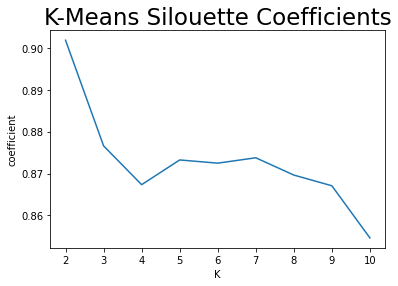

In [104]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), silouette_coefficients)
plt.title('K-Means Silouette Coefficients', fontsize = 23)
plt.xlabel('K') 
plt.ylabel('coefficient') 

#### Silhouette Hierarchical clustering

In [105]:
silouette_coefficients = []

for k in range(2, 11):
  agg_cl = AgglomerativeClustering(n_clusters=k)
  agg_cl.fit_predict(df_jerarquic_pca)
  score = silhouette_score(df_jerarquic_pca, agg_cl.labels_)
  silouette_coefficients.append(score)

Text(0, 0.5, 'coefficient')

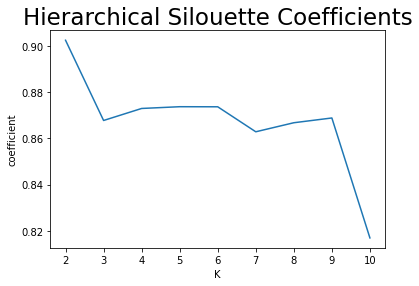

In [117]:
fig, ax = plt.subplots()
ax.plot(range(2, 11), silouette_coefficients)
plt.title('Hierarchical Silouette Coefficients', fontsize = 23)
plt.xlabel('K') 
plt.ylabel('coefficient') 

Tras silhouette score concluimos que quizas el número de clusters adecuado debería de haber sido 2. Coincide en ambos modelos.

Según Hierarchical model entre 3 y 9 no habría mucha diferencia.

Para K-Means esta claro que después de 2 clusters, sería 3 los idoneos, pero no con mucha diferencia respecto a tener 5 6 o 7 clusters.

## Knee Point

El knee point se define como el punto de máxima curvatura en un sistema. Es apropiado parala selección de un valor apropiado de k en K-means clustering.

In [118]:
inertia = []
for n in range (1,9): 
    kmeans = KMeans(n_clusters= n, random_state=42)
    kmeans.fit(Xpca)
    inertia.append(kmeans.inertia_)

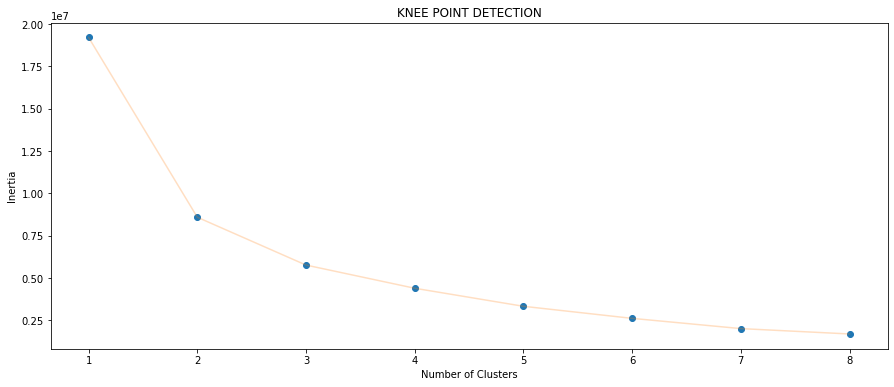

In [119]:
plt.figure(figsize= (15,6))
plt.plot(np.arange(1 , 9) , inertia , 'o')
plt.plot(np.arange(1 , 9) , inertia , '-' , alpha = 0.25)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.title('KNEE POINT DETECTION');

In [128]:
kn = KneeLocator(x=list(range (1,9)), y=inertia, curve='convex', direction='decreasing')
kn.knee

3

El número optimo de clusters es 3 según Knee Point. 

Rehacemos el ejercicio 1 a continuación y vemos en que se diferencia.

In [129]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(Xpca)

y_pred = kmeans.predict(Xpca)

Text(0.5, 1.0, 'VISUALIZATION OF CLUSTERS')

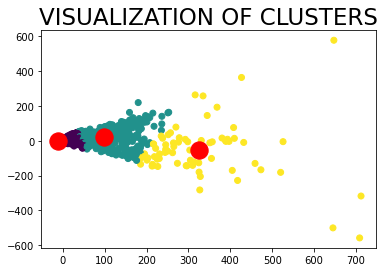

In [130]:
fig, ax = plt.subplots()
ax.scatter(x=Xpca[:,0], y=Xpca[:,1], c=y_pred)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('VISUALIZATION OF CLUSTERS', fontsize = 23)

Text(0.5, 1.0, 'Histogram of clusters')

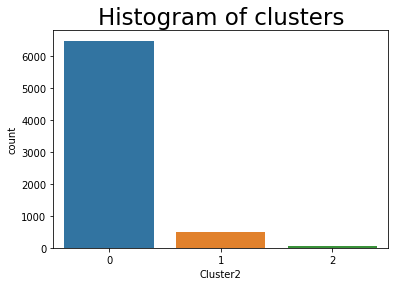

In [131]:
df['Cluster2'] = y_pred
pl = sns.countplot(x=df['Cluster2'])
pl.set_title("Histogram of clusters", fontsize = 23)

In [133]:
print("Entrenamiento con 3 Clusters")
print(df.groupby(['Cluster2'])[['num_comments','num_shares']].agg(['count', np.mean, max, min]).round(2))
print('\n')
print("Entrenamiento con 4 Clusters")
print(df.groupby(['Cluster'])[['num_comments','num_shares']].agg(['count', np.mean, max, min]).round(2) )

Entrenamiento con 3 Clusters
         num_comments                       num_shares                  
                count     mean    max   min      count    mean   max min
Cluster2                                                                
0                6495    50.59   1686     0       6495   10.63   295   0
1                 483  1593.37   5000    18        483  337.14  1260  34
2                  72  6715.65  20990  1778         72  698.04  3424  25


Entrenamiento con 4 Clusters
        num_comments                       num_shares                  
               count     mean    max   min      count    mean   max min
Cluster                                                                
0               6209    27.54   1186     0       6209    4.29   153   0
1                204  2976.55   6407    18        204  503.90  2139  60
2                603   834.50   3146     3        603  209.65   564  26
3                 34  8832.15  20990  2903         34  774.62  3424  2

La agrupación que se hace con 3 clusters respecto a 4 es muy similar.En el cluster mas numerosos se concentran las entradas con menos comentarios y menos número de veces compartido.

Es decir, el apesar de que el número de clusters a cambiado, el agrupamiento sigue siendo similar y bajo los mismos criterios.